In [1]:
# Libraries import
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import plotly.graph_objs as go
#import plotly.express as px
from plotly.offline import init_notebook_mode

from bokeh.plotting import figure, show, output_file, ColumnDataSource
from bokeh.models import HoverTool, GeoJSONDataSource, LinearColorMapper

from googletrans import Translator

#import statsmodels.api as sn

import requests
import json

In [2]:
# Data import - 'Datos abiertos COVID-19 (Colombia)'
data = pd.DataFrame.from_dict(requests.get('https://www.datos.gov.co/resource/gt2j-8ykr.json?$limit=9999999999999').json())
#data

In [3]:
# Data import - 'World Health Organization (WHO) COVID-19 Global Data'
who_data = pd.read_csv('https://covid19.who.int/WHO-COVID-19-global-data.csv')
#who_data

In [4]:
# Data import - 'Colombian Departments GeoJson'
d_geojson = requests.get('https://gist.githubusercontent.com/john-guerra/43c7656821069d00dcbc/raw/be6a6e239cd5b5b803c6e7c2ec405b793a9064dd/Colombia.geo.json').json()
#d_geojson

In [5]:
# Data import - 'Colombian Towns & Cities GeoJson'
tc_geojson = requests.get('https://gist.githubusercontent.com/john-guerra/727e8992e9599b9d9f1dbfdc4c8e479e/raw/090f8b935a437e24d65b64d87598fbb437c006da/colombia-municipios.json').json()
#tc_geojson

In [6]:
# Data cleaning and adjusting
translator = Translator()
translations = {}

departments = {}
towns_cities = {}
status_counts = []

data.columns = ['Id de caso', 'Fecha de notificación', 'Código DIVIPOLA', 'Ciudad de ubicación', 'Departamento', 'Estado', 'Edad', 'Sexo', 'Tipo', 'Severidad','País de procedencia', 'Fecha de inicio de síntomas', 'Fecha de diagnóstico', 'Fecha de recuperación', 'Fecha de reporte web', 'Tipo de recuperación', 'Código departamento', 'Código país', 'Pertenencia étnica', 'Ubicación recuperado', 'Nombre grupo étnico', 'Fecha de defunción']
#who_data.columns = ['']

for element in data['País de procedencia'].unique():
    translations[element] = translator.translate(" ".join(element.split(" ")[:2])).text if type(element) !=  float else 'Colombia'

data['País de procedencia'].replace(translations, inplace=True)

for column in ['Edad', 'Código departamento', 'Código DIVIPOLA']:
    data[column] = data[column].apply(lambda x: int(x))
    
data['Clasificación de edad'] = pd.cut(x=data['Edad'], bins=[0,10,20,30,40,50,60,70,80,90,np.inf], include_lowest=True, labels=['0 - 10', '10 - 20', '20 - 30', '30 - 40', '40 - 50', '50 - 60', '60 - 70', '70 - 80', '80 - 90', '90 - 100+'])

for column in ['Ciudad de ubicación', 'Estado', 'Sexo', 'Tipo', 'Severidad', 'País de procedencia', 'Ubicación recuperado']:
    data[column] = data[column].str.capitalize()
    
for column in ['Fecha de notificación', 'Fecha de inicio de síntomas', 'Fecha de defunción', 'Fecha de diagnóstico', 'Fecha de recuperación', 'Fecha de reporte web']:
    data[column] = data[column].str.slice(0,10).replace(r'(\d+)-(\d+)-(\d+)', r'\1-\2-\3', regex=True).apply(lambda x: pd.to_datetime(x, dayfirst=True, errors='ignore'))

for element in d_geojson['features']:
    departments[int(element['properties']['DPTO'])] = element['properties']['NOMBRE_DPT']
    
#for element in tc_geojson['geometries']:
#    towns_cities[int(element['id'])] = element['properties']['name']
    
status_counts = data['Estado'].value_counts().to_list()

date = data['Fecha de reporte web'].iloc[-1].strftime('%Y-%m-%d')
    
data = data[['Id de caso', 'Fecha de reporte web', 'Fecha de diagnóstico', 'Fecha de notificación', 'Fecha de inicio de síntomas', 'Fecha de recuperación', 'Fecha de defunción', 'Severidad', 'Estado', 'Tipo', 'Tipo de recuperación', 'Ubicación recuperado', 'Ciudad de ubicación', 'Departamento', 'País de procedencia', 'Edad', 'Clasificación de edad', 'Sexo', 'Pertenencia étnica', 'Nombre grupo étnico', 'Código departamento', 'Código país', 'Código DIVIPOLA']]
data = data.set_index('Id de caso')

In [7]:
# Helper functions
def GetBars(df):
    d = df.to_dict('list')
    #for i in range(df[]):

def numbers(div): #x
    for i in range(0, len(ax.patches)//div, 1):
        height = 0
        for j in range(0, div, 1):
            height += ax.patches[j*(len(ax.patches)//div)+i].get_height()
        ax.text(ax.patches[i].get_x()+(ax.patches[i].get_width()/10),height+(height/100)+10, int(height), fontsize=8, color='darkgray', rotation=90)

def numbers_H(div): #y
    for i in range(0, len(ax.patches)//div, 1):
        width = 0
        for j in range(0, div, 1):
            width += ax.patches[j*(len(ax.patches)//div)+i].get_width()
        ax.text(width+(width/100)+10,ax.patches[i].get_y()+(ax.patches[i].get_height()/10), int(width), fontsize=8, color='darkgray', rotation=0)

In [8]:
# Testing
#bars = GetBars()

bar_chart = go.Figure(
    data = go.Histogram(
        
    ),
    layout = go.Layout(
        title="Casos confirmados VS Clasificación de Edad (Estado)",
        yaxis_title="Clasificación de edad",
        xaxis_title="Casos confirmados",
    )
)
#bar_chart.show()

#data.groupby(['Clasificación de edad', 'Estado']).size().unstack().fillna(0).sort_index(ascending=False).to_dict('list')

In [9]:
# In-line plots libraries import
%matplotlib inline
init_notebook_mode(connected = True)

# COVID-19 Status (Colombia) 🇨🇴

#### Fuente: <a href='https://datos.gov.co'>Datos Abiertos - Colombia</a>

### - Panorama nacional COVID-19 (Colombia)

In [10]:
local_map = go.Figure(go.Choropleth(
    z=data['Código departamento'].value_counts().sort_index().tolist(),
    locations=[departments[key] for key in sorted(departments.keys())],
    featureidkey='properties.NOMBRE_DPT',
    geojson=d_geojson,
    colorscale='blues',
    colorbar_title="Casos confirmados COVID-19",
    autocolorscale = False,
    reversescale = True,
    marker_line_color='darkgray',
    marker_line_width=0.5,
))

local_map.update_geos(showcountries=False, showcoastlines=False, showland=False, fitbounds='locations')

local_map.update_layout(
    margin={"r":0,"t":0,"l":0,"b":0},
    geo = dict(
        showframe = False,
        showcoastlines = False,
        projection_type = 'equirectangular'
    ),
    annotations = [
        dict(
            x=0,
            y=0.25,
            xref='paper',
            yref='paper',
            text= f' - Colombia - ',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.18,
            xref='paper',
            yref='paper',
            text= f'Casos confirmados: {len(data.index):,}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.15,
            xref='paper',
            yref='paper',
            text= f'Casos activos: {status_counts[1]+status_counts[2]+status_counts[4]+status_counts[5]:,}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.12,
            xref='paper',
            yref='paper',
            text= f'Recuperados: {status_counts[0]:,} - Fallecidos: {status_counts[3]:,}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.08,
            xref='paper',
            yref='paper',
            text= f'Fecha: {date}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.05,
            xref='paper',
            yref='paper',
            text='Fuente: <a href="https://datos.gov.co">Datos Abiertos - Colombia</a>',
            showarrow = False
        ),
    ]
)

local_map.show()

### - Dataset COVID-19 (Colombia)

In [11]:
data

Fecha de reporte web Fecha de diagnóstico Fecha de notificación  \
Id de caso                                                                   
1                    2020-03-06           2020-03-06            2020-03-02   
2                    2020-03-09           2020-03-09            2020-03-06   
3                    2020-03-09           2020-03-09            2020-03-07   
4                    2020-03-11           2020-03-11            2020-03-09   
5                    2020-03-11           2020-03-11            2020-03-09   
...                         ...                  ...                   ...   
855088               2020-10-04           2020-09-25            2020-09-14   
855089               2020-10-04           2020-09-30            2020-09-19   
855090               2020-10-04           2020-09-30            2020-09-19   
855091               2020-10-04           2020-09-30            2020-09-19   
855092               2020-10-04           2020-09-30            2020-09-19   

           Fecha de inicio de síntomas Fecha de recuperación  \
Id de caso                                                     
1                           2020-02-27            2020-03-13   
2                           2020-03-04            2020-03-19   
3                           2020-02-29            2020-03-15   
4                           2020-03-06            2020-03-26   
5                           2020-03-08            2020-03-23   
...                                ...                   ...   
855088                      2020-09-10                   NaT   
855089                      2020-09-15                   NaT   
855090                      2020-09-15                   NaT   
855091                      2020-09-15                   NaT   
855092                      2020-09-15                   NaT   

           Fecha de defunción Severidad      Estado         Tipo  \
Id de caso                                                         
1                         NaT      Leve  Recuperado    Importado   
2                         NaT      Leve  Recuperado    Importado   
3                         NaT      Leve  Recuperado    Importado   
4                         NaT      Leve  Recuperado  Relacionado   
5                         NaT      Leve  Recuperado  Relacionado   
...                       ...       ...         ...          ...   
855088                    NaT      Leve        Casa   En estudio   
855089                    NaT      Leve        Casa   En estudio   
855090                    NaT      Leve        Casa   En estudio   
855091                    NaT      Leve        Casa   En estudio   
855092                    NaT      Leve        Casa   En estudio   

           Tipo de recuperación  ...     Departamento País de procedencia  \
Id de caso                       ...                                        
1                           PCR  ...      Bogotá D.C.               Italy   
2                           PCR  ...  Valle del Cauca               Spain   
3                           PCR  ...        Antioquia               Spain   
4                           PCR  ...        Antioquia            Colombia   
5                           PCR  ...        Antioquia            Colombia   
...                         ...  ...              ...                 ...   
855088                      NaN  ...           Nariño            Colombia   
855089                      NaN  ...           Nariño            Colombia   
855090                      NaN  ...           Nariño            Colombia   
855091                      NaN  ...           Nariño            Colombia   
855092                      NaN  ...  Valle del Cauca            Colombia   

           Edad Clasificación de edad  Sexo Pertenencia étnica  \
Id de caso                                                       
1            19               10 - 20     F               Otro   
2            34               30 - 40     M              Negro   
3           

### - TOP 50: Casos activos VS Ciudad de ubicación (Estado)

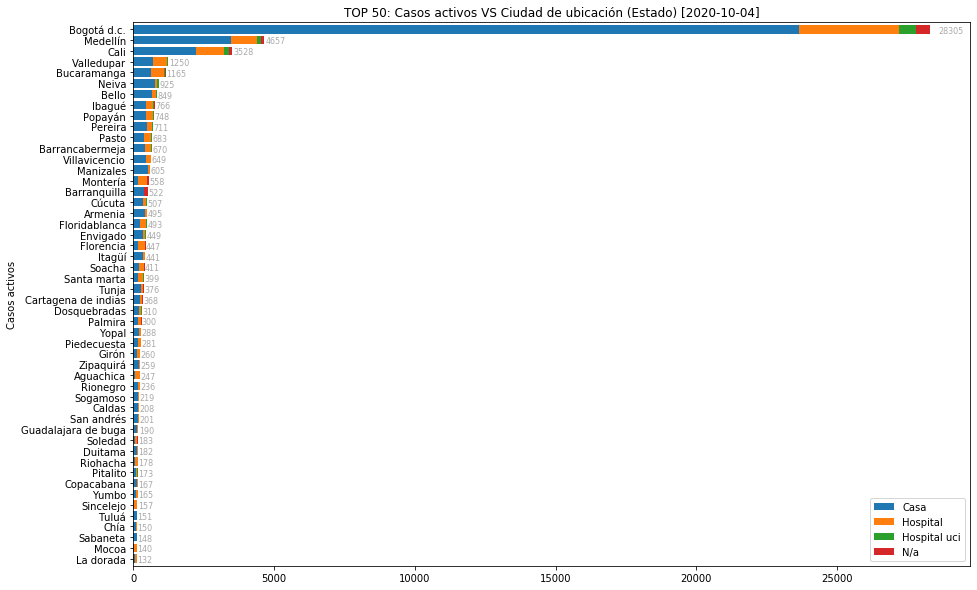

In [12]:
li = data.groupby(['Ciudad de ubicación', 'Estado']).size().unstack().fillna(0).iloc[:, [True, False, True, True, True, False]]
li['Total'] = li.sum(axis=1)
ax = li.sort_values('Total').tail(50).iloc[:,:len(li.columns)-1].plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=(f'TOP 50: Casos activos VS Ciudad de ubicación (Estado) [{date}]'))
ax.set_ylabel('Casos activos')
ax.legend(loc='lower right')
div = len(li.columns)-1
numbers_H(div)

In [13]:
li.sort_values('Total', ascending=False).head(50)

Estado                  Casa  Hospital  Hospital uci    N/a    Total
Ciudad de ubicación                                                 
Bogotá d.c.          23634.0    3579.0         587.0  505.0  28305.0
Medellín              3490.0     914.0         150.0  103.0   4657.0
Cali                  2233.0    1003.0         167.0  125.0   3528.0
Valledupar             694.0     498.0          36.0   22.0   1250.0
Bucaramanga            639.0     463.0          36.0   27.0   1165.0
Neiva                  793.0      68.0          54.0   10.0    925.0
Bello                  688.0     132.0          17.0   12.0    849.0
Ibagué                 468.0     255.0          15.0   28.0    766.0
Popayán                445.0     253.0          31.0   19.0    748.0
Pereira                499.0     162.0          39.0   11.0    711.0
Pasto                  386.0     255.0          22.0   20.0    683.0
Barrancabermeja        424.0     218.0          16.0   12.0    670.0
Villavicencio          475.0     144.0          11.0   19.0    649.0
Manizales              525.0      64.0           4.0   12.0    605.0
Montería               186.0     308.0           7.0   57.0    558.0
Barranquilla           376.0      24.0           0.0  122.0    522.0
Cúcuta                 370.0      93.0          30.0   14.0    507.0
Armenia                421.0      72.0           1.0    1.0    495.0
Floridablanca          255.0     219.0          13.0    6.0    493.0
Envigado               365.0      68.0          11.0    5.0    449.0
Florencia              158.0     264.0           9.0   16.0    447.0
Itagüí                 364.0      62.0           7.0    8.0    441.0
Soacha                 200.0     188.0          13.0   10.0    411.0
Santa marta            162.0     200.0          12.0   25.0    399.0
Tunja                  293.0      73.0           4.0    6.0    376.0
Cartagena de indias    252.0      65.0          11.0   40.0    368.0
Dosquebradas           227.0      69.0          10.0    4.0    310.0
Palmira                158.0     120.0          12.0   10.0    300.0
Yopal                  193.0      87.0           7.0    1.0    288.0
Piedecuesta            175.0      94.0          10.0    2.0    281.0
Girón                  142.0     106.0           5.0    7.0    260.0
Zipaquirá              224.0      26.0           5.0    4.0    259.0
Aguachica               65.0     173.0           8.0    1.0    247.0
Rionegro               177.0      52.0           4.0    3.0    236.0
Sogamoso               173.0      43.0           1.0    2.0    219.0
Caldas                 182.0      26.0           0.0    0.0    208.0
San andrés             168.0      28.0           3.0    2.0    201.0
Guadalajara de buga    136.0      49.0           2.0    3.0    190.0
Soledad                 76.0      57.0           5.0   45.0    183.0
Duitama                138.0      39.0           1.0    4.0    182.0
Riohacha                72.0      96.0           4.0    6.0    178.0
Pitalito               118.0      39.0          11.0    5.0    173.0
Copacabana             149.0      15.0           1.0    2.0    167.0
Yumbo                  111.0      47.0           2.0    5.0    165.0
Sincelejo               45.0      89.0           4.0   19.0    157.0
Tuluá                  122.0      22.0           4.0    3.0    151.0
Chía                    91.0      50.0           6.0    3.0    150.0
Sabaneta               128.0      19.0           0.0    1.0    148.0
Mocoa                   45.0      95.0           0.0    0.0    140.0
La dorada               80.0      45.0           4.0    3.0    132.0

### - Casos activos VS Departamento (Estado)

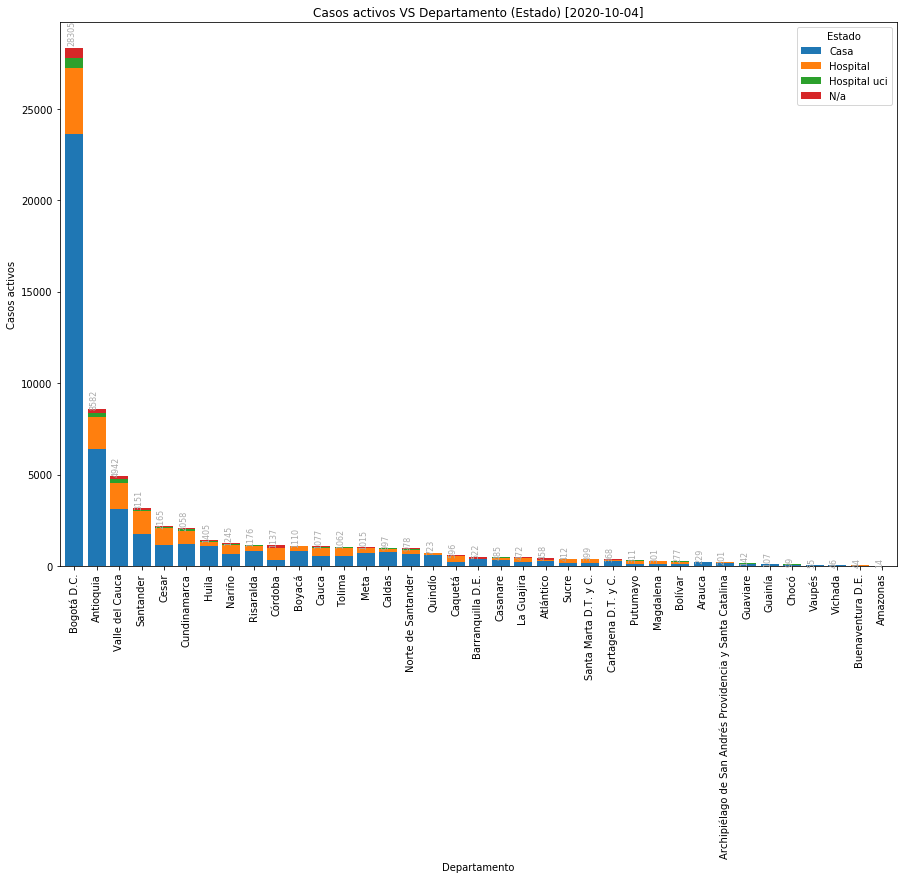

In [14]:
li = data.groupby(['Departamento', 'Estado']).size().unstack().fillna(0).iloc[:, [True, False, True, True, True, False]]
li['Total'] = li.sum(axis=1)
ax = li.sort_values('Total').iloc[:,:len(li.columns)-1][::-1].plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos activos VS Departamento (Estado) [{date}]'))
ax.set_ylabel('Casos activos')
div = len(li.columns)-1
numbers(div)

In [15]:
li.sort_values('Total', ascending=False)

Estado                                                 Casa  Hospital  \
Departamento                                                            
Bogotá D.C.                                         23634.0    3579.0   
Antioquia                                            6385.0    1772.0   
Valle del Cauca                                      3119.0    1448.0   
Santander                                            1757.0    1237.0   
Cesar                                                1151.0     927.0   
Cundinamarca                                         1228.0     715.0   
Huila                                                1122.0     167.0   
Nariño                                                671.0     494.0   
Risaralda                                             828.0     280.0   
Córdoba                                               339.0     658.0   
Boyacá                                                803.0     273.0   
Cauca                                                 531.0     449.0   
Tolima                                                576.0     415.0   
Meta                                                  719.0     254.0   
Caldas                                                785.0     172.0   
Norte de Santander                                    678.0     210.0   
Quindío                                               623.0      96.0   
Caquetá                                               224.0     334.0   
Barranquilla D.E.                                     376.0      24.0   
Casanare                                              333.0     134.0   
La Guajira                                            208.0     232.0   
Atlántico                                             249.0      99.0   
Sucre                                                 145.0     227.0   
Santa Marta D.T. y C.                                 162.0     200.0   
Cartagena D.T. y C.                                   252.0      65.0   
Putumayo                                               91.0     208.0   
Magdalena                                              87.0     164.0   
Bolívar                                               138.0      95.0   
Arauca                                                201.0      25.0   
Archipiélago de San Andrés Providencia y Santa ...    168.0      28.0   
Guaviare                                              130.0       8.0   
Guainía                                                89.0      18.0   
Chocó                                                  31.0      51.0   
Vaupés                                                 49.0       4.0   
Vichada                                                38.0       7.0   
Buenaventura D.E.                                       9.0      23.0   
Amazonas                                                5.0       5.0   

Estado                                              Hospital uci    N/a  \
Departamento                                                              
Bogotá D.C.                                                587.0  505.0   
Antioquia                                                  233.0  192.0   
Valle del Cauca                                            205.0  170.0   
Santander                                                   89.0   68.0   
Cesar                                                       49.0   38.0   
Cundinamarca                                                68.0   47.0   
Huila                                                       90.0   26.0   
Nariño                                                      35.0   45.0   
Risaralda                                                   51.0   17.0   
Córdoba                                                     15.0  125.0   
Boyacá                                                      11.0   23.0   
Cauca                                                       62.0   35.0   
Tolima                                                      25.0   46.0   
Meta                       

### - Casos confirmados VS Departamento (Estado)

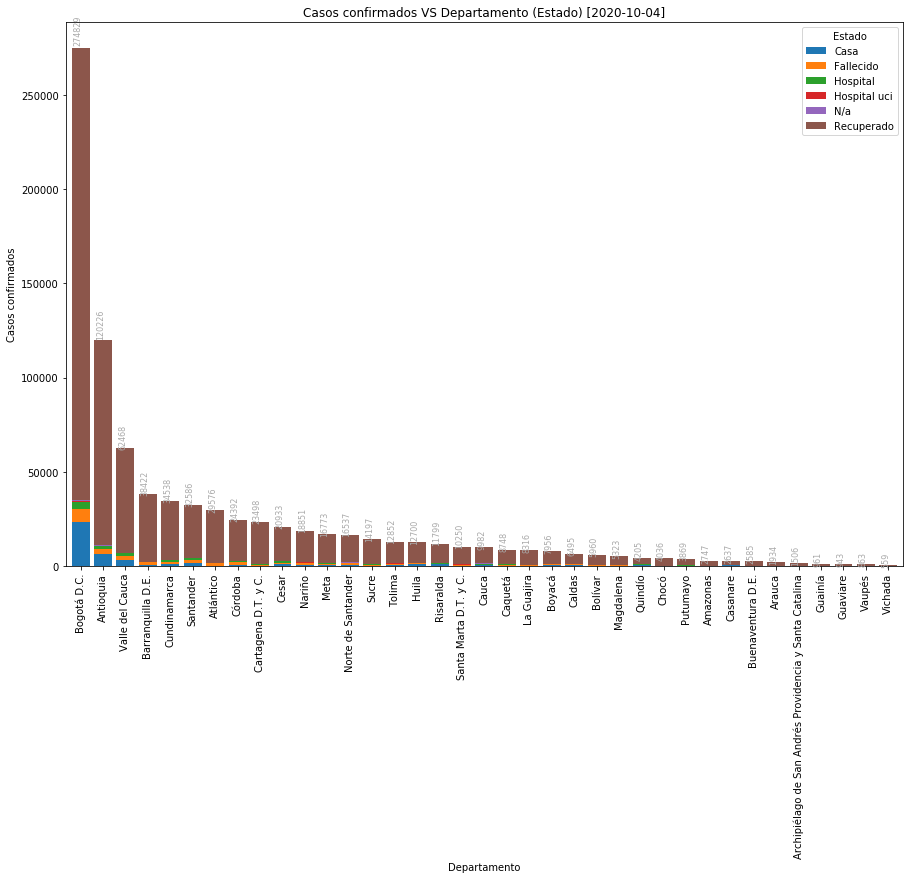

In [16]:
li = data.groupby(['Departamento', 'Estado']).size().unstack().fillna(0)
li['Total'] = li.sum(axis=1)
ax = li.sort_values('Total').iloc[:, :len(li.columns)-1][::-1].plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados VS Departamento (Estado) [{date}]'))
ax.set_ylabel('Casos confirmados')
div = len(li.columns)-1
numbers(div)

In [17]:
li.sort_values('Total', ascending=False)

Estado                                                 Casa  Fallecido  \
Departamento                                                             
Bogotá D.C.                                         23634.0     6898.0   
Antioquia                                            6385.0     2505.0   
Valle del Cauca                                      3119.0     2187.0   
Barranquilla D.E.                                     376.0     1681.0   
Cundinamarca                                         1228.0     1032.0   
Santander                                            1757.0     1359.0   
Atlántico                                             249.0     1396.0   
Córdoba                                               339.0     1560.0   
Cartagena D.T. y C.                                   252.0      556.0   
Cesar                                                1151.0      646.0   
Nariño                                                671.0      695.0   
Meta                                                  719.0      435.0   
Norte de Santander                                    678.0      923.0   
Sucre                                                 145.0      584.0   
Tolima                                                576.0      362.0   
Huila                                                1122.0      401.0   
Risaralda                                             828.0      270.0   
Santa Marta D.T. y C.                                 162.0      450.0   
Cauca                                                 531.0      283.0   
Caquetá                                               224.0      311.0   
La Guajira                                            208.0      322.0   
Boyacá                                                803.0      164.0   
Caldas                                                785.0      142.0   
Bolívar                                               138.0      230.0   
Magdalena                                              87.0      400.0   
Quindío                                               623.0      117.0   
Chocó                                                  31.0      158.0   
Putumayo                                               91.0      179.0   
Amazonas                                                5.0      117.0   
Casanare                                              333.0       56.0   
Buenaventura D.E.                                       9.0      172.0   
Arauca                                                201.0       56.0   
Archipiélago de San Andrés Providencia y Santa ...    168.0       16.0   
Guainía                                                89.0       15.0   
Guaviare                                              130.0       18.0   
Vaupés                                                 49.0       11.0   
Vichada                                                38.0        5.0   

Estado                                              Hospital  Hospital uci  \
Departamento                                                                 
Bogotá D.C.                                           3579.0         587.0   
Antioquia                                             1772.0         233.0   
Valle del Cauca                                       1448.0         205.0   
Barranquilla D.E.                                       24.0           0.0   
Cundinamarca                                           715.0          68.0   
Santander                                             1237.0          89.0   
Atlántico                                               99.0           9.0   
Córdoba                                                658.0          15.0   
Cartagena D.T. y C.                                     65.0          11.0   
Cesar                                                  927.0          49.0   
Nariño                                                 494.0          35.0   
Meta                                                   254.0          15.0   
Norte de Santander   

### - Casos confirmados VS Departamento (Sexo)

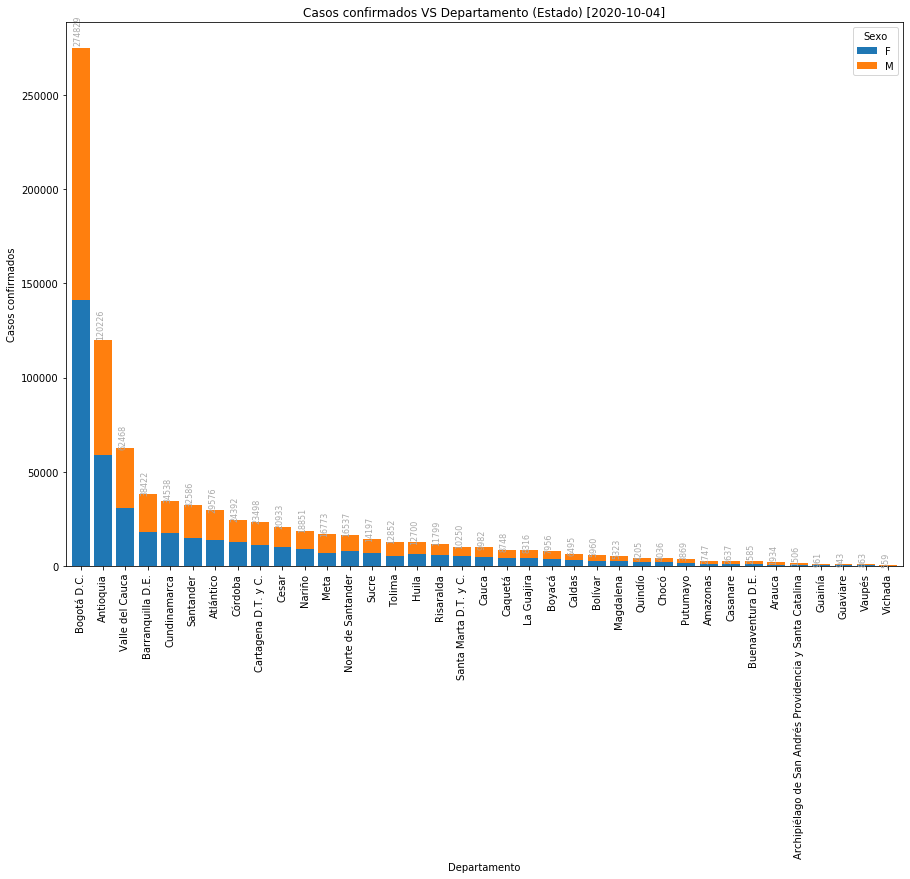

In [18]:
li = data.groupby(['Departamento', 'Sexo']).size().unstack().fillna(0)
li['Total'] = li.sum(axis=1)
ax = li.sort_values('Total').iloc[:, :len(li.columns)-1][::-1].plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados VS Departamento (Estado) [{date}]'))
ax.set_ylabel('Casos confirmados')
div = len(li.columns)-1
numbers(div)

In [19]:
li.sort_values('Total', ascending=False)

Sexo                                                     F       M   Total
Departamento                                                              
Bogotá D.C.                                         141317  133512  274829
Antioquia                                            59107   61119  120226
Valle del Cauca                                      30661   31807   62468
Barranquilla D.E.                                    18251   20171   38422
Cundinamarca                                         17606   16932   34538
Santander                                            15000   17586   32586
Atlántico                                            14039   15537   29576
Córdoba                                              12712   11680   24392
Cartagena D.T. y C.                                  11082   12416   23498
Cesar                                                10372   10561   20933
Nariño                                                9226    9625   18851
Meta                                                  6979    9794   16773
Norte de Santander                                    7793    8744   16537
Sucre                                                 7047    7150   14197
Tolima                                                5406    7446   12852
Huila                                                 6133    6567   12700
Risaralda                                             5812    5987   11799
Santa Marta D.T. y C.                                 5155    5095   10250
Cauca                                                 4966    5016    9982
Caquetá                                               4281    4467    8748
La Guajira                                            4297    4019    8316
Boyacá                                                3778    4178    7956
Caldas                                                3191    3304    6495
Bolívar                                               2860    3100    5960
Magdalena                                             2719    2604    5323
Quindío                                               2038    2167    4205
Chocó                                                 1924    2112    4036
Putumayo                                              1807    2062    3869
Amazonas                                              1184    1563    2747
Casanare                                              1092    1545    2637
Buenaventura D.E.                                      956    1629    2585
Arauca                                                 769    1165    1934
Archipiélago de San Andrés Providencia y Santa ...     790     716    1506
Guainía                                                452     509     961
Guaviare                                               378     565     943
Vaupés                                                 385     478     863
Vichada                                                205     354     559

### - Recuperados y Fallecidos VS Departamento

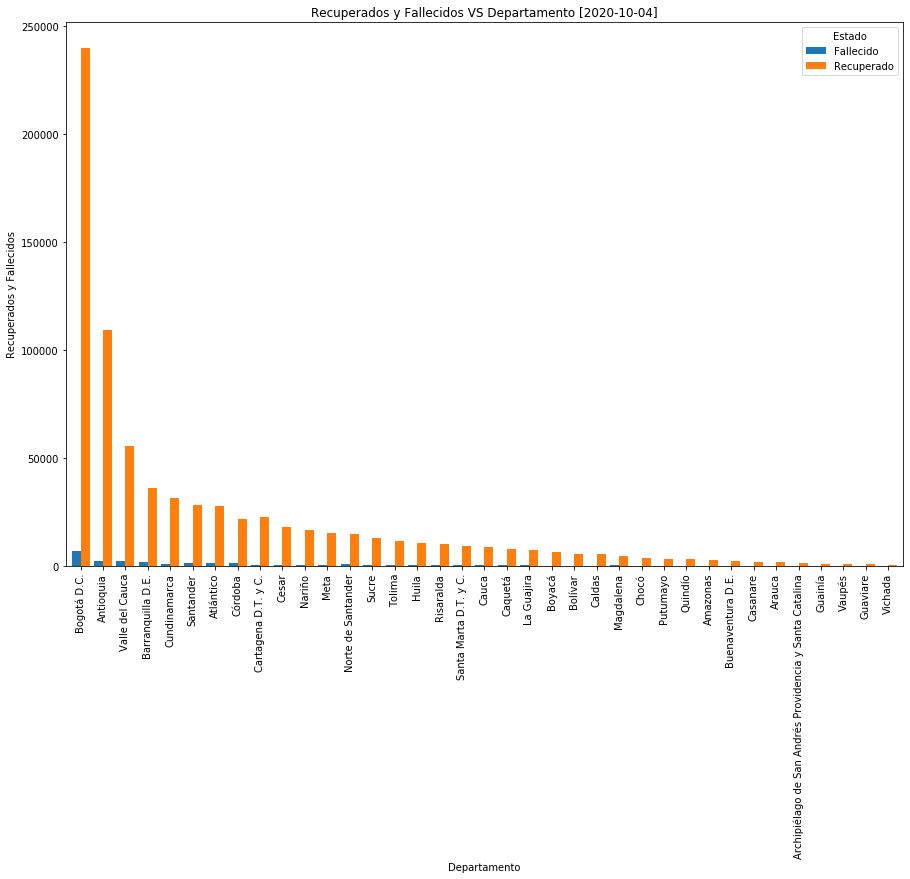

In [20]:
li = data.groupby(['Departamento', 'Estado']).size().unstack().fillna(0).iloc[:, [False, True, False, False, False, True]]
li['Total'] = li.sum(axis=1)
ax = li.sort_values('Total').iloc[:,:len(li.columns)-1][::-1].plot(kind='bar', width=0.8, stacked=False, figsize=(15,10), title=(f'Recuperados y Fallecidos VS Departamento [{date}]'))
ax.set_ylabel('Recuperados y Fallecidos')
div = len(li.columns)-1
#numbers(div)

In [21]:
li.sort_values('Total', ascending=False).iloc[:,:len(li.columns)-1]

Estado                                              Fallecido  Recuperado
Departamento                                                             
Bogotá D.C.                                            6898.0    239626.0
Antioquia                                              2505.0    109139.0
Valle del Cauca                                        2187.0     55339.0
Barranquilla D.E.                                      1681.0     36219.0
Cundinamarca                                           1032.0     31448.0
Santander                                              1359.0     28076.0
Atlántico                                              1396.0     27722.0
Córdoba                                                1560.0     21695.0
Cartagena D.T. y C.                                     556.0     22574.0
Cesar                                                   646.0     18122.0
Nariño                                                  695.0     16911.0
Meta                                                    435.0     15323.0
Norte de Santander                                      923.0     14636.0
Sucre                                                   584.0     13201.0
Tolima                                                  362.0     11428.0
Huila                                                   401.0     10894.0
Risaralda                                               270.0     10353.0
Santa Marta D.T. y C.                                   450.0      9401.0
Cauca                                                   283.0      8622.0
Caquetá                                                 311.0      7841.0
La Guajira                                              322.0      7522.0
Boyacá                                                  164.0      6682.0
Bolívar                                                 230.0      5453.0
Caldas                                                  142.0      5356.0
Magdalena                                               400.0      4622.0
Chocó                                                   158.0      3779.0
Putumayo                                                179.0      3379.0
Quindío                                                 117.0      3365.0
Amazonas                                                117.0      2616.0
Buenaventura D.E.                                       172.0      2369.0
Casanare                                                 56.0      2096.0
Arauca                                                   56.0      1649.0
Archipiélago de San Andrés Providencia y Santa ...       16.0      1289.0
Guainía                                                  15.0       839.0
Vaupés                                                   11.0       797.0
Guaviare                                                 18.0       783.0
Vichada                                                   5.0       508.0

* Fallecimientos relacionados al COVID-19.

### - Casos confirmados acumulado VS Fecha de diagnóstico (Estado)

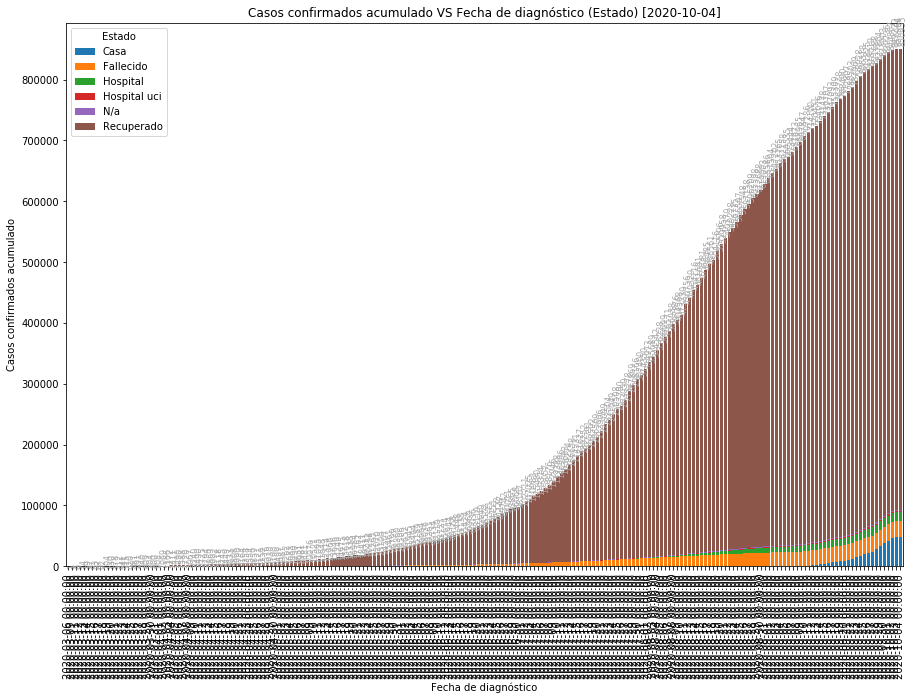

In [22]:
ax = data.groupby(['Fecha de diagnóstico', 'Estado']).size().unstack().fillna(0).cumsum().plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados acumulado VS Fecha de diagnóstico (Estado) [{date}]'))
ax.set_ylabel('Casos confirmados acumulado')
div = len(data['Estado'].unique())
numbers(div)

In [23]:
data.groupby(['Fecha de diagnóstico', 'Estado']).size().unstack().fillna(0).cumsum().tail(60)[::-1]

Estado                   Casa  Fallecido  Hospital  Hospital uci     N/a  \
Fecha de diagnóstico                                                       
2020-10-04            47934.0    26498.0   15092.0        1745.0  1861.0   
2020-10-03            47933.0    26498.0   15092.0        1745.0  1861.0   
2020-10-02            46318.0    26498.0   14976.0        1744.0  1861.0   
2020-10-01            42243.0    26479.0   14752.0        1743.0  1861.0   
2020-09-30            37923.0    26444.0   14486.0        1743.0  1860.0   
2020-09-29            33207.0    26399.0   14202.0        1737.0  1860.0   
2020-09-28            28276.0    26351.0   13920.0        1733.0  1859.0   
2020-09-27            24262.0    26296.0   13650.0        1723.0  1852.0   
2020-09-26            22298.0    26261.0   13508.0        1717.0  1849.0   
2020-09-25            19581.0    26193.0   13281.0        1703.0  1846.0   
2020-09-24            17394.0    26140.0   13119.0        1695.0  1843.0   
2020-09-23            14800.0    26004.0   12716.0        1674.0  1835.0   
2020-09-22            11789.0    25865.0   12330.0        1658.0  1824.0   
2020-09-21            10279.0    25731.0   11985.0        1630.0  1819.0   
2020-09-20             8974.0    25613.0   11755.0        1624.0  1809.0   
2020-09-19             8246.0    25528.0   11577.0        1608.0  1808.0   
2020-09-18             7314.0    25413.0   11389.0        1589.0  1802.0   
2020-09-17             6420.0    25276.0   11124.0        1550.0  1789.0   
2020-09-16             5495.0    25142.0   10862.0        1515.0  1774.0   
2020-09-15             4582.0    24969.0   10603.0        1473.0  1764.0   
2020-09-14             3432.0    24820.0   10419.0        1435.0  1756.0   
2020-09-13             2471.0    24659.0   10228.0        1397.0  1742.0   
2020-09-12             2047.0    24596.0   10112.0        1378.0  1737.0   
2020-09-11             1223.0    24430.0    9947.0        1355.0  1728.0   
2020-09-10              180.0    24270.0    9742.0        1325.0  1715.0   
2020-09-09              171.0    24078.0    9454.0        1300.0  1699.0   
2020-09-08              166.0    23877.0    9187.0        1280.0  1685.0   
2020-09-07              156.0    23702.0    8992.0        1250.0  1680.0   
2020-09-06              153.0    23517.0    8776.0        1228.0  1667.0   
2020-09-05              150.0    23423.0    8673.0        1222.0  1664.0   
2020-09-04              146.0    23239.0    8331.0        1200.0  1650.0   
2020-09-03              145.0    23060.0    8181.0        1159.0  1635.0   
2020-09-02              137.0    22897.0    8004.0        1140.0  1627.0   
2020-09-01               92.0    22579.0    7827.0        1111.0  1607.0   
2020-08-31               84.0    22375.0    7655.0        1086.0  1597.0   
2020-08-30               81.0    22126.0    7395.0        1056.0  1581.0   
2020-08-29               80.0    21965.0    7215.0        1033.0  1564.0   
2020-08-28               77.0    21770.0    7027.0        1015.0  1551.0   
2020-08-27               71.0    21500.0    6747.0         973.0  1535.0   
2020-08-26               66.0    21247.0    6484.0         948.0  1518.0   
2020-08-25               65.0    20930.0    6233.0         920.0  1503.0   
2020-08-24               61.0    20650.0    5966.0         887.0  1484.0   
2020-08-23               56.0    20328.0    5688.0         864.0  1463.0   
2020-08-22               56.0    20138.0    5485.0         854.0  1453.0   
2020-08-21               55.0    19857.0    5138.0         843.0  1438.0   
2020-08-20               54.0    19544.0    4818.0         820.0  1411.0   
2020-08-19               50.0    19091.0    4396.0         785.0  1387.0   
2020-08-18               39.0    18727.0    4071.0         751.0  1361.0   
2020-08-17               39.0    18450.0    3847.0         737.0  1333.0   
2020-08-16               36.0    18230.0    3651.0         721.0  1316.0   
2020-08-15               29.0    17907.0    3352

### - Casos confirmados VS Fecha de diagnóstico (Estado)

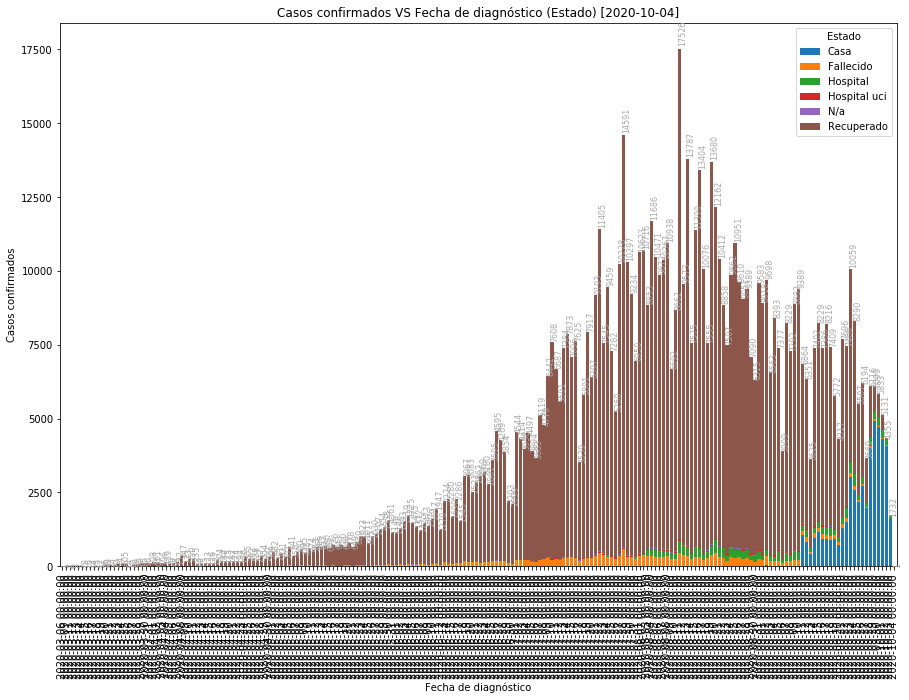

In [24]:
ax = data.groupby(['Fecha de diagnóstico', 'Estado']).size().unstack().fillna(0).plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados VS Fecha de diagnóstico (Estado) [{date}]'))
ax.set_ylabel('Casos confirmados')
div = len(data['Estado'].unique())
numbers(div)

In [25]:
data.groupby(['Fecha de diagnóstico', 'Estado']).size().unstack().fillna(0).tail(60)[::-1]

Estado                  Casa  Fallecido  Hospital  Hospital uci   N/a  \
Fecha de diagnóstico                                                    
2020-10-04               1.0        0.0       0.0           0.0   0.0   
2020-10-03            1615.0        0.0     116.0           1.0   0.0   
2020-10-02            4075.0       19.0     224.0           1.0   0.0   
2020-10-01            4320.0       35.0     266.0           0.0   1.0   
2020-09-30            4716.0       45.0     284.0           6.0   0.0   
2020-09-29            4931.0       48.0     282.0           4.0   1.0   
2020-09-28            4014.0       55.0     270.0          10.0   7.0   
2020-09-27            1964.0       35.0     142.0           6.0   3.0   
2020-09-26            2717.0       68.0     227.0          14.0   3.0   
2020-09-25            2187.0       53.0     162.0           8.0   3.0   
2020-09-24            2594.0      136.0     403.0          21.0   8.0   
2020-09-23            3011.0      139.0     386.0          16.0  11.0   
2020-09-22            1510.0      134.0     345.0          28.0   5.0   
2020-09-21            1305.0      118.0     230.0           6.0  10.0   
2020-09-20             728.0       85.0     178.0          16.0   1.0   
2020-09-19             932.0      115.0     188.0          19.0   6.0   
2020-09-18             894.0      137.0     265.0          39.0  13.0   
2020-09-17             925.0      134.0     262.0          35.0  15.0   
2020-09-16             913.0      173.0     259.0          42.0  10.0   
2020-09-15            1150.0      149.0     184.0          38.0   8.0   
2020-09-14             961.0      161.0     191.0          38.0  14.0   
2020-09-13             424.0       63.0     116.0          19.0   5.0   
2020-09-12             824.0      166.0     165.0          23.0   9.0   
2020-09-11            1043.0      160.0     205.0          30.0  13.0   
2020-09-10               9.0      192.0     288.0          25.0  16.0   
2020-09-09               5.0      201.0     267.0          20.0  14.0   
2020-09-08              10.0      175.0     195.0          30.0   5.0   
2020-09-07               3.0      185.0     216.0          22.0  13.0   
2020-09-06               3.0       94.0     103.0           6.0   3.0   
2020-09-05               4.0      184.0     342.0          22.0  14.0   
2020-09-04               1.0      179.0     150.0          41.0  15.0   
2020-09-03               8.0      163.0     177.0          19.0   8.0   
2020-09-02              45.0      318.0     177.0          29.0  20.0   
2020-09-01               8.0      204.0     172.0          25.0  10.0   
2020-08-31               3.0      249.0     260.0          30.0  16.0   
2020-08-30               1.0      161.0     180.0          23.0  17.0   
2020-08-29               3.0      195.0     188.0          18.0  13.0   
2020-08-28               6.0      270.0     280.0          42.0  16.0   
2020-08-27               5.0      253.0     263.0          25.0  17.0   
2020-08-26               1.0      317.0     251.0          28.0  15.0   
2020-08-25               4.0      280.0     267.0          33.0  19.0   
2020-08-24               5.0      322.0     278.0          23.0  21.0   
2020-08-23               0.0      190.0     203.0          10.0  10.0   
2020-08-22               1.0      281.0     347.0          11.0  15.0   
2020-08-21               1.0      313.0     320.0          23.0  27.0   
2020-08-20               4.0      453.0     422.0          35.0  24.0   
2020-08-19              11.0      364.0     325.0          34.0  26.0   
2020-08-18               0.0      277.0     224.0          14.0  28.0   
2020-08-17               3.0      220.0     196.0          16.0  17.0   
2020-08-16               7.0      323.0     299.0          23.0  16.0   
2020-08-15               2.0      322.0     288.0          18.0  14.0   
2020-08-14               2.0      259.0     168.0          12.0  15.0   
2020-08-13               0.0      341.0     326.0         

### - Casos confirmados VS Clasificación de edad (Estado)

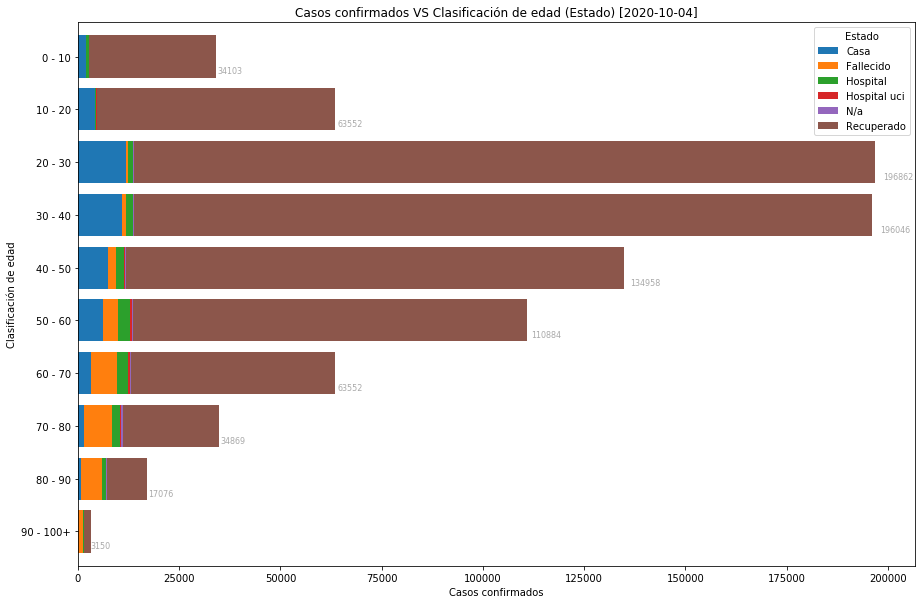

In [26]:
ax = data.groupby(['Clasificación de edad', 'Estado']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados VS Clasificación de edad (Estado) [{date}]'))
ax.set_xlabel('Casos confirmados')
div = len(data['Estado'].unique())
numbers_H(div)

In [27]:
data.groupby(['Clasificación de edad', 'Estado']).size().unstack().fillna(0)

Estado                  Casa  Fallecido  Hospital  Hospital uci  N/a  \
Clasificación de edad                                                  
0 - 10                  1886         42       799            44   39   
10 - 20                 4096         47       437            16   37   
20 - 30                11977        338      1259            75   80   
30 - 40                10944        845      1722           154   74   
40 - 50                 7541       1865      2059           240  137   
50 - 60                 6068       3910      2893           417  230   
60 - 70                 3139       6385      2808           437  407   
70 - 80                 1525       6933      1981           274  436   
80 - 90                  655       5175      1001            85  360   
90 - 100+                103       1172       138             5   88   

Estado                 Recuperado  
Clasificación de edad              
0 - 10                      31293  
10 - 20                     58919  
20 - 30                    183133  
30 - 40                    182307  
40 - 50                    123116  
50 - 60                     97366  
60 - 70                     50376  
70 - 80                     23720  
80 - 90                      9800  
90 - 100+                    1644

### - Casos confirmados acumulado VS Fecha de diagnóstico (Sexo)

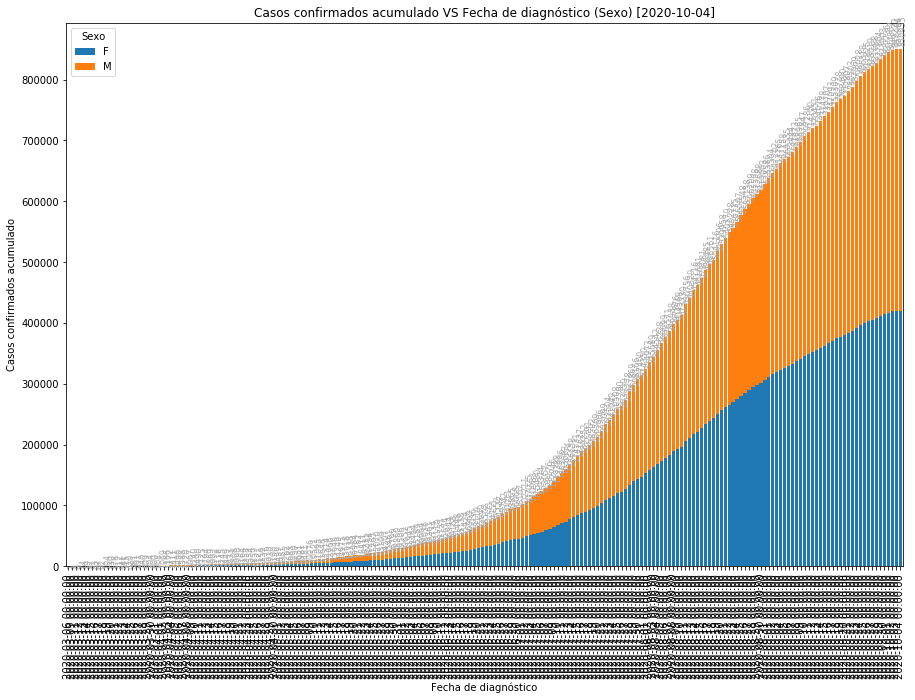

In [28]:
ax = data.groupby(['Fecha de diagnóstico', 'Sexo']).size().unstack().fillna(0).cumsum().plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados acumulado VS Fecha de diagnóstico (Sexo) [{date}]'))
ax.set_ylabel('Casos confirmados acumulado')
div = len(data['Sexo'].unique())
numbers(div)

In [29]:
data.groupby(['Fecha de diagnóstico', 'Sexo']).size().unstack().fillna(0).cumsum().tail(60)[::-1]

Sexo                         F         M
Fecha de diagnóstico                    
2020-10-04            419812.0  431143.0
2020-10-03            419811.0  431143.0
2020-10-02            418922.0  430300.0
2020-10-01            416704.0  428163.0
2020-09-30            414089.0  425647.0
2020-09-29            411078.0  422825.0
2020-09-28            407854.0  419950.0
2020-09-27            404663.0  417025.0
2020-09-26            402628.0  415391.0
2020-09-25            399443.0  412382.0
2020-09-24            396598.0  409720.0
2020-09-23            392403.0  405625.0
2020-09-22            387454.0  400515.0
2020-09-21            383610.0  396893.0
2020-09-20            379654.0  393153.0
2020-09-19            377393.0  391097.0
2020-09-18            374576.0  388142.0
2020-09-17            370719.0  384590.0
2020-09-16            366652.0  380441.0
2020-09-15            362871.0  376836.0
2020-09-14            358562.0  372916.0
2020-09-13            354783.0  369293.0
2020-09-12            352938.0  367513.0
2020-09-11            349592.0  364508.0
2020-09-10            345941.0  361295.0
2020-09-09            341151.0  356696.0
2020-09-08            336628.0  352337.0
2020-09-07            332907.0  348766.0
2020-09-06            328640.0  344804.0
2020-09-05            326639.0  342896.0
2020-09-04            323150.0  339008.0
2020-09-03            318656.0  335109.0
2020-09-02            315303.0  331899.0
2020-09-01            310348.0  327156.0
2020-08-31            305883.0  322703.0
2020-08-30            300837.0  318166.0
2020-08-29            297636.0  315052.0
2020-08-28            294053.0  311545.0
2020-08-27            289333.0  306876.0
2020-08-26            284766.0  302392.0
2020-08-25            279869.0  297679.0
2020-08-24            274369.0  292228.0
2020-08-23            269450.0  287285.0
2020-08-22            265651.0  283577.0
2020-08-21            261477.0  278893.0
2020-08-20            256226.0  273732.0
2020-08-19            250093.0  267703.0
2020-08-18            242954.0  261162.0
2020-08-17            239306.0  257255.0
2020-08-16            233987.0  252498.0
2020-08-15            226976.0  246105.0
2020-08-14            221195.0  240496.0
2020-08-13            217317.0  236799.0
2020-08-12            210424.0  229905.0
2020-08-11            205679.0  225077.0
2020-08-10            196600.0  216630.0
2020-08-09            192256.0  212312.0
2020-08-08            188799.0  209077.0
2020-08-07            183470.0  203468.0
2020-08-06            178407.0  198164.0

### - Casos confirmados VS Fecha de diagnóstico (Sexo)

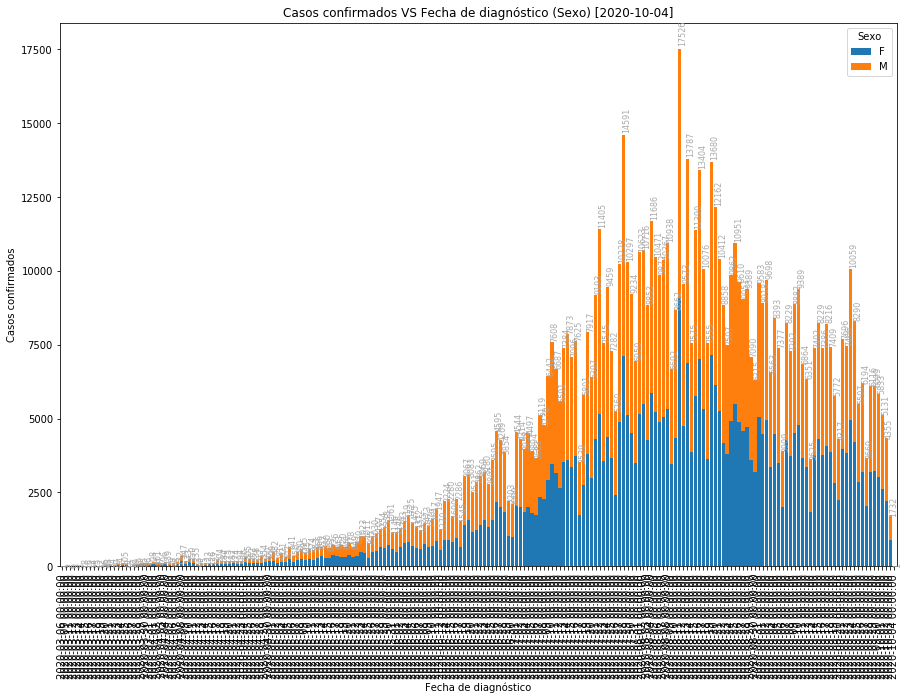

In [30]:
ax = data.groupby(['Fecha de diagnóstico', 'Sexo']).size().unstack().fillna(0).plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados VS Fecha de diagnóstico (Sexo) [{date}]'))
ax.set_ylabel('Casos confirmados')
div = len(data['Sexo'].unique())
numbers(div)

In [31]:
data.groupby(['Fecha de diagnóstico', 'Sexo']).size().unstack().fillna(0).tail(60)[::-1]

Sexo                       F       M
Fecha de diagnóstico                
2020-10-04               1.0     0.0
2020-10-03             889.0   843.0
2020-10-02            2218.0  2137.0
2020-10-01            2615.0  2516.0
2020-09-30            3011.0  2822.0
2020-09-29            3224.0  2875.0
2020-09-28            3191.0  2925.0
2020-09-27            2035.0  1634.0
2020-09-26            3185.0  3009.0
2020-09-25            2845.0  2662.0
2020-09-24            4195.0  4095.0
2020-09-23            4949.0  5110.0
2020-09-22            3844.0  3622.0
2020-09-21            3956.0  3740.0
2020-09-20            2261.0  2056.0
2020-09-19            2817.0  2955.0
2020-09-18            3857.0  3552.0
2020-09-17            4067.0  4149.0
2020-09-16            3781.0  3605.0
2020-09-15            4309.0  3920.0
2020-09-14            3779.0  3623.0
2020-09-13            1845.0  1780.0
2020-09-12            3346.0  3005.0
2020-09-11            3651.0  3213.0
2020-09-10            4790.0  4599.0
2020-09-09            4523.0  4359.0
2020-09-08            3721.0  3571.0
2020-09-07            4267.0  3962.0
2020-09-06            2001.0  1908.0
2020-09-05            3489.0  3888.0
2020-09-04            4494.0  3899.0
2020-09-03            3353.0  3210.0
2020-09-02            4955.0  4743.0
2020-09-01            4465.0  4453.0
2020-08-31            5046.0  4537.0
2020-08-30            3201.0  3114.0
2020-08-29            3583.0  3507.0
2020-08-28            4720.0  4669.0
2020-08-27            4567.0  4484.0
2020-08-26            4897.0  4713.0
2020-08-25            5500.0  5451.0
2020-08-24            4919.0  4943.0
2020-08-23            3799.0  3708.0
2020-08-22            4174.0  4684.0
2020-08-21            5251.0  5161.0
2020-08-20            6133.0  6029.0
2020-08-19            7139.0  6541.0
2020-08-18            3648.0  3907.0
2020-08-17            5319.0  4757.0
2020-08-16            7011.0  6393.0
2020-08-15            5781.0  5609.0
2020-08-14            3878.0  3697.0
2020-08-13            6893.0  6894.0
2020-08-12            4745.0  4828.0
2020-08-11            9079.0  8447.0
2020-08-10            4344.0  4318.0
2020-08-09            3457.0  3235.0
2020-08-08            5329.0  5609.0
2020-08-07            5063.0  5304.0
2020-08-06            4888.0  4984.0

### - Casos confirmados VS Clasificación de edad (Sexo)

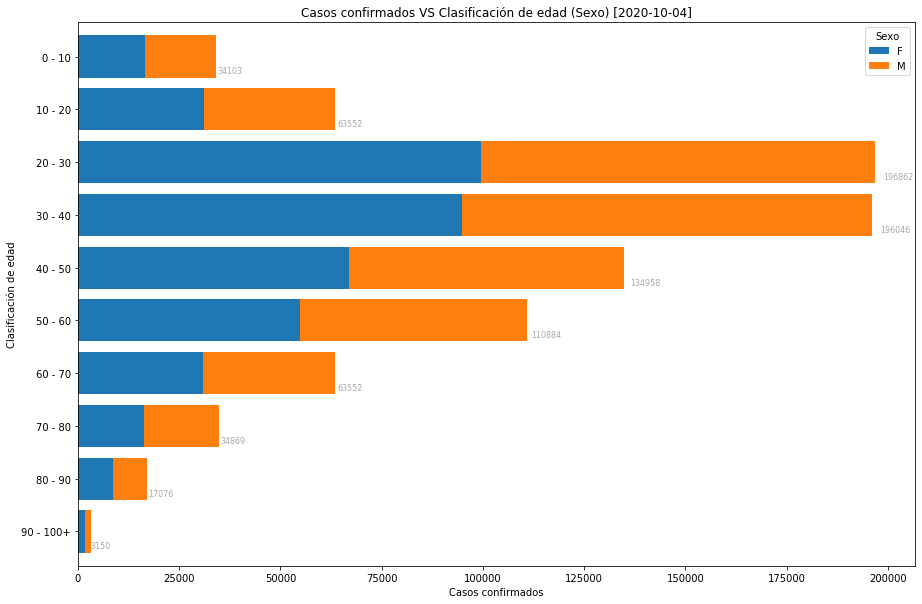

In [32]:
ax = data.groupby(['Clasificación de edad', 'Sexo']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados VS Clasificación de edad (Sexo) [{date}]'))
ax.set_xlabel('Casos confirmados')
div = len(data['Sexo'].unique())
numbers_H(div)

In [33]:
data.groupby(['Clasificación de edad', 'Sexo']).size().unstack().fillna(0)

Sexo                       F       M
Clasificación de edad               
0 - 10                 16638   17465
10 - 20                31127   32425
20 - 30                99549   97313
30 - 40                94897  101149
40 - 50                66956   68002
50 - 60                54784   56100
60 - 70                30873   32679
70 - 80                16402   18467
80 - 90                 8758    8318
90 - 100+               1786    1364

### - Casos confirmados VS Estado (Sexo)

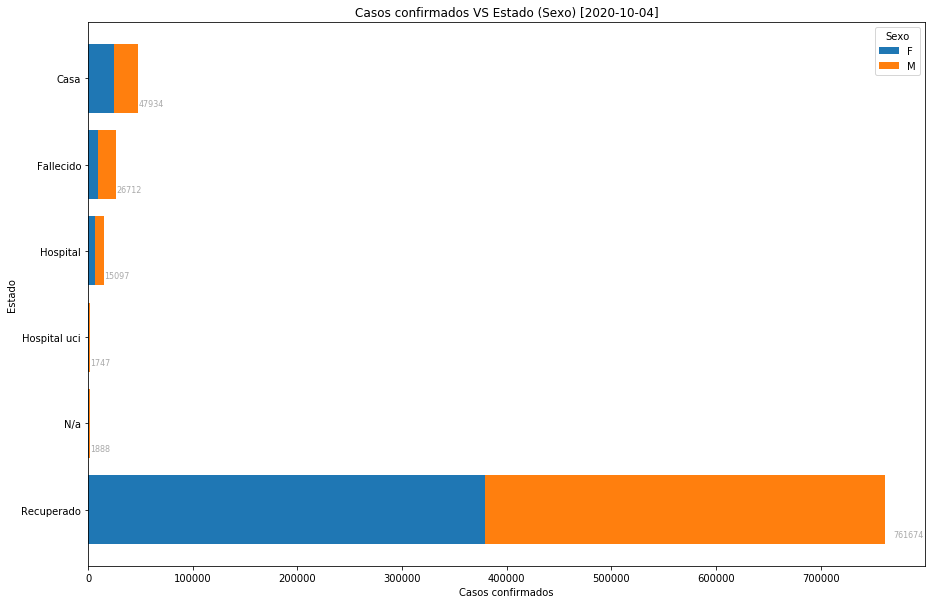

In [34]:
ax = data.groupby(['Estado', 'Sexo']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados VS Estado (Sexo) [{date}]'))
ax.set_xlabel('Casos confirmados')
div = len(data['Sexo'].unique())
numbers_H(div)

In [35]:
data.groupby(['Estado', 'Sexo']).size().unstack().fillna(0)

Sexo               F       M
Estado                      
Casa           25165   22769
Fallecido       9570   17142
Hospital        6578    8519
Hospital uci     598    1149
N/a              811    1077
Recuperado    379048  382626

### - Casos confirmados VS Tipo de contagio (Sexo)

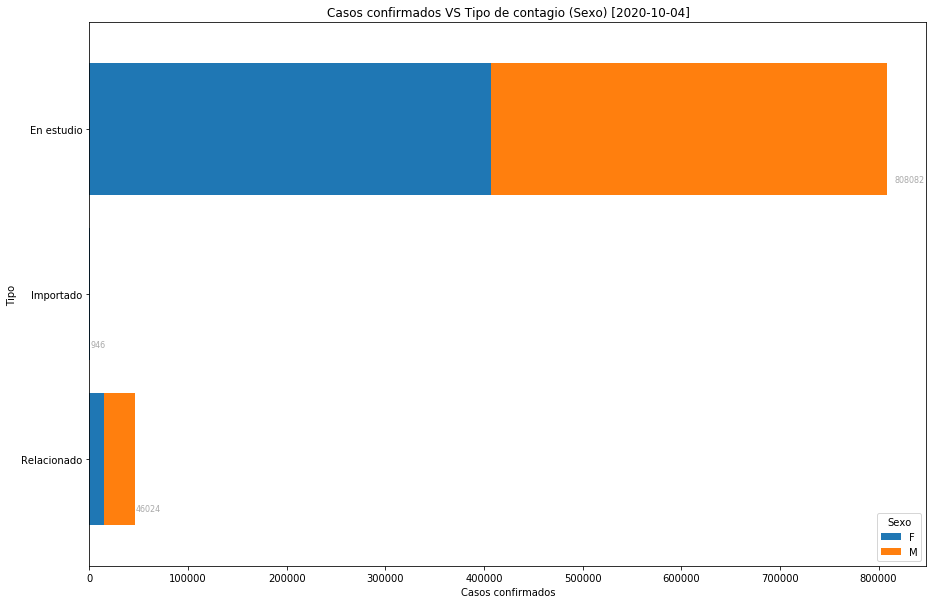

In [36]:
ax = data.groupby(['Tipo', 'Sexo']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados VS Tipo de contagio (Sexo) [{date}]'))
ax.set_xlabel('Casos confirmados')
div = len(data['Sexo'].unique())
numbers_H(div)

In [37]:
data.groupby(['Tipo', 'Sexo']).size().unstack().fillna(0)

Sexo              F       M
Tipo                       
En estudio   406785  401297
Importado       440     506
Relacionado   14545   31479

### - Casos confirmados acumulado VS Fecha de diagnóstico (Clasificación de edad)

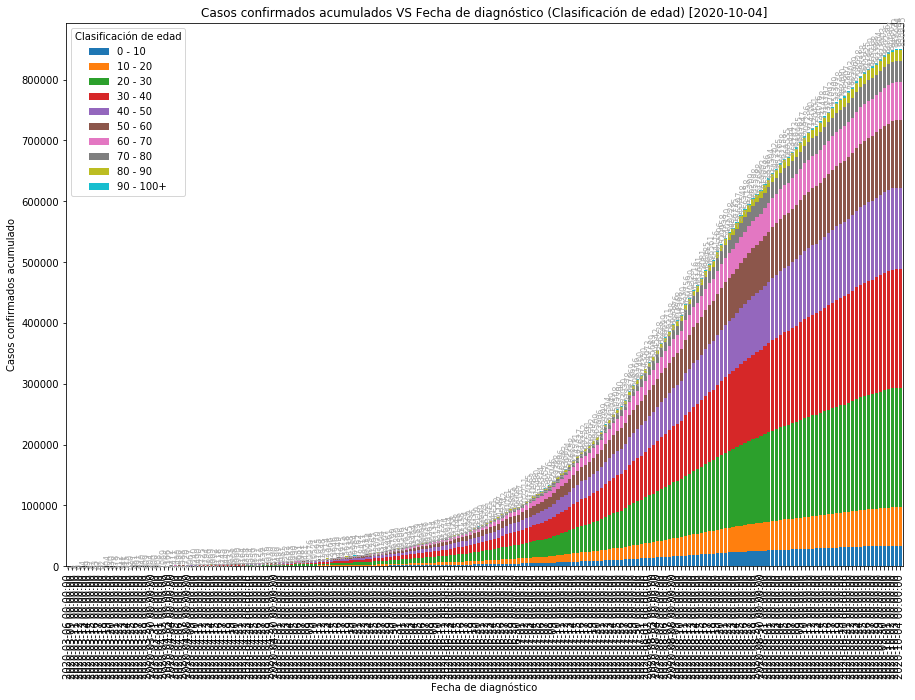

In [38]:
ax = data.groupby(['Fecha de diagnóstico', 'Clasificación de edad']).size().unstack().fillna(0).cumsum().plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados acumulados VS Fecha de diagnóstico (Clasificación de edad) [{date}]'))
ax.set_ylabel('Casos confirmados acumulado')
div = len(data['Clasificación de edad'].unique())
numbers(div)

In [39]:
data.groupby(['Fecha de diagnóstico', 'Clasificación de edad']).size().unstack().fillna(0).cumsum().tail(60)[::-1]

Clasificación de edad  0 - 10  10 - 20  20 - 30  30 - 40  40 - 50  50 - 60  \
Fecha de diagnóstico                                                         
2020-10-04              33960    63259   195865   195054   134354   110385   
2020-10-03              33960    63259   195865   195054   134354   110385   
2020-10-02              33884    63137   195467   194727   134101   110141   
2020-10-01              33768    62811   194475   193795   133365   109540   
2020-09-30              33592    62453   193305   192591   132571   108858   
2020-09-29              33424    61996   191839   191224   131669   108121   
2020-09-28              33231    61501   190411   189848   130736   107339   
2020-09-27              33000    61028   188912   188443   129814   106580   
2020-09-26              32837    60754   188160   187651   129222   106067   
2020-09-25              32632    60270   186775   186230   128222   105309   
2020-09-24              32436    59860   185392   185071   127363   104589   
2020-09-23              32189    59318   183798   183258   125911   103367   
2020-09-22              31762    58433   181039   180932   124615   102247   
2020-09-21              31452    57865   179257   179301   123511   101338   
2020-09-20              31201    57287   177430   177555   122304   100348   
2020-09-19              31032    56978   176489   176601   121620    99785   
2020-09-18              30811    56512   175155   175330   120757    99017   
2020-09-17              30529    55979   173491   173589   119618    98043   
2020-09-16              30253    55399   171524   171726   118348    96905   
2020-09-15              29959    54882   169827   170042   117159    95922   
2020-09-14              29660    54202   167991   168122   115818    94891   
2020-09-13              29376    53675   166298   166364   114634    93957   
2020-09-12              29241    53435   165425   165498   114082    93490   
2020-09-11              28986    52863   163961   164118   113065    92702   
2020-09-10              28759    52431   162783   162555   111805    91604   
2020-09-09              28378    51706   160390   160322   110474    90469   
2020-09-08              28061    51058   158278   158175   109074    89314   
2020-09-07              27800    50520   156622   156506   107946    88389   
2020-09-06              27493    49915   154764   154673   106615    87305   
2020-09-05              27355    49638   153900   153772   105994    86818   
2020-09-04              27080    48980   152197   152090   104850    85915   
2020-09-03              26749    48445   150247   150170   103526    84802   
2020-09-02              26513    47958   148695   148693   102469    83924   
2020-09-01              26123    47295   146526   146533   100958    82645   
2020-08-31              25777    46593   144466   144495    99579    81470   
2020-08-30              25355    45876   142176   142351    98053    80285   
2020-08-29              25109    45403   140688   140923    97060    79478   
2020-08-28              24851    44867   139027   139368    95953    78515   
2020-08-27              24523    44237   136925   137161    94468    77250   
2020-08-26              24165    43582   134819   135088    93019    76085   
2020-08-25              23812    42862   132748   132897    91471    74877   
2020-08-24              23416    42148   130263   130320    89701    73414   
2020-08-23              23050    41427   127979   128094    88153    72139   
2020-08-22              22739    40819   126192   126351    87041    71148   
2020-08-21              22415    40157   124151   124245    85707    70024   
2020-08-20              21990    39406   121680   121876    84060    68660   
2020-08-19              21502    38543   119008   119144    82131    67033   
2020-08-18              20870    37543   115930   116095    79881    65297   
2020-08-17              20615    37027   114251   114386    78676    64262   
2020-08-16            

### - Casos confirmados VS Fecha de diagnóstico (Clasificación de edad)

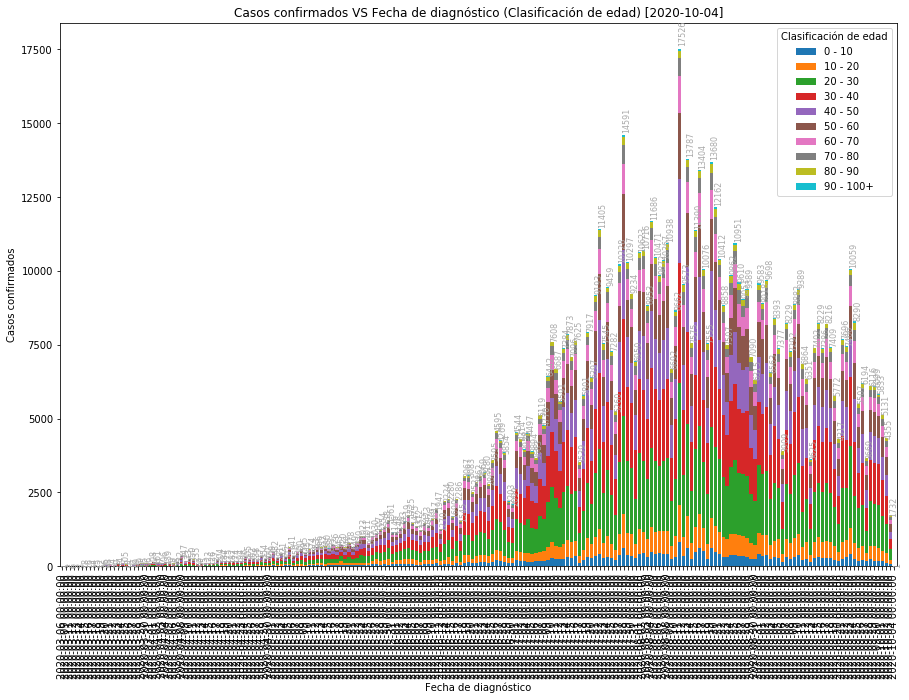

In [40]:
ax = data.groupby(['Fecha de diagnóstico', 'Clasificación de edad']).size().unstack().fillna(0).plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados VS Fecha de diagnóstico (Clasificación de edad) [{date}]'))
ax.set_ylabel('Casos confirmados')
div = len(data['Clasificación de edad'].unique())
numbers(div)

In [41]:
data.groupby(['Fecha de diagnóstico', 'Clasificación de edad']).size().unstack().fillna(0).tail(60)[::-1]

Clasificación de edad  0 - 10  10 - 20  20 - 30  30 - 40  40 - 50  50 - 60  \
Fecha de diagnóstico                                                         
2020-10-04                  0        0        0        0        0        0   
2020-10-03                 76      122      398      327      253      244   
2020-10-02                116      326      992      932      736      601   
2020-10-01                176      358     1170     1204      794      682   
2020-09-30                168      457     1466     1367      902      737   
2020-09-29                193      495     1428     1376      933      782   
2020-09-28                231      473     1499     1405      922      759   
2020-09-27                163      274      752      792      592      513   
2020-09-26                205      484     1385     1421     1000      758   
2020-09-25                196      410     1383     1159      859      720   
2020-09-24                247      542     1594     1813     1452     1222   
2020-09-23                427      885     2759     2326     1296     1120   
2020-09-22                310      568     1782     1631     1104      909   
2020-09-21                251      578     1827     1746     1207      990   
2020-09-20                169      309      941      954      684      563   
2020-09-19                221      466     1334     1271      863      768   
2020-09-18                282      533     1664     1741     1139      974   
2020-09-17                276      580     1967     1863     1270     1138   
2020-09-16                294      517     1697     1684     1189      983   
2020-09-15                299      680     1836     1920     1341     1031   
2020-09-14                284      527     1693     1758     1184      934   
2020-09-13                135      240      873      866      552      467   
2020-09-12                255      572     1464     1380     1017      788   
2020-09-11                227      432     1178     1563     1260     1098   
2020-09-10                381      725     2393     2233     1331     1135   
2020-09-09                317      648     2112     2147     1400     1155   
2020-09-08                261      538     1656     1669     1128      925   
2020-09-07                307      605     1858     1833     1331     1084   
2020-09-06                138      277      864      901      621      487   
2020-09-05                275      658     1703     1682     1144      903   
2020-09-04                331      535     1950     1920     1324     1113   
2020-09-03                236      487     1552     1477     1057      878   
2020-09-02                390      663     2169     2160     1511     1279   
2020-09-01                346      702     2060     2038     1379     1175   
2020-08-31                422      717     2290     2144     1526     1185   
2020-08-30                246      473     1488     1428      993      807   
2020-08-29                258      536     1661     1555     1107      963   
2020-08-28                328      630     2102     2207     1485     1265   
2020-08-27                358      655     2106     2073     1449     1165   
2020-08-26                353      720     2071     2191     1548     1208   
2020-08-25                396      714     2485     2577     1770     1463   
2020-08-24                366      721     2284     2226     1548     1275   
2020-08-23                311      608     1787     1743     1112      991   
2020-08-22                324      662     2041     2106     1334     1124   
2020-08-21                425      751     2471     2369     1647     1364   
2020-08-20                488      863     2672     2732     1929     1627   
2020-08-19                632     1000     3078     3049     2250     1736   
2020-08-18                255      516     1679     1709     1205     1035   
2020-08-17                516      764     2237     2123     1608     1350   
2020-08-16            

### - Casos confirmados VS Estado (Clasificación de edad)

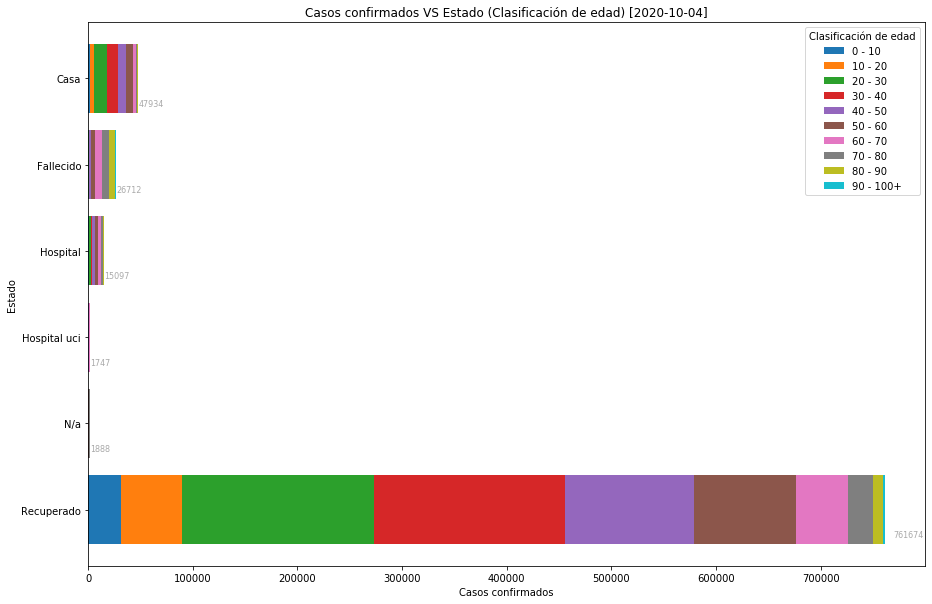

In [42]:
ax = data.groupby(['Estado', 'Clasificación de edad']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados VS Estado (Clasificación de edad) [{date}]'))
ax.set_xlabel('Casos confirmados')
div = len(data['Clasificación de edad'].unique())
numbers_H(div)

In [43]:
data.groupby(['Estado', 'Clasificación de edad']).size().unstack().fillna(0)

Clasificación de edad  0 - 10  10 - 20  20 - 30  30 - 40  40 - 50  50 - 60  \
Estado                                                                       
Casa                     1886     4096    11977    10944     7541     6068   
Fallecido                  42       47      338      845     1865     3910   
Hospital                  799      437     1259     1722     2059     2893   
Hospital uci               44       16       75      154      240      417   
N/a                        39       37       80       74      137      230   
Recuperado              31293    58919   183133   182307   123116    97366   

Clasificación de edad  60 - 70  70 - 80  80 - 90  90 - 100+  
Estado                                                       
Casa                      3139     1525      655        103  
Fallecido                 6385     6933     5175       1172  
Hospital                  2808     1981     1001        138  
Hospital uci               437      274       85          5  
N/a                        407      436      360         88  
Recuperado               50376    23720     9800       1644

### - Casos confirmados VS Tipo de contagio (Clasificación de edad)

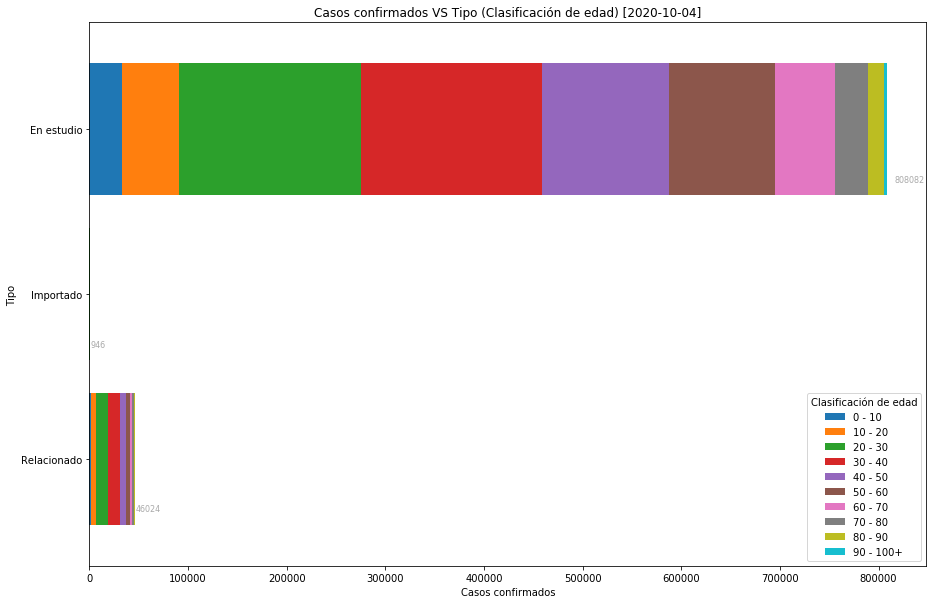

In [44]:
ax = data.groupby(['Tipo', 'Clasificación de edad']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados VS Tipo (Clasificación de edad) [{date}]'))
ax.set_xlabel('Casos confirmados')
div = len(data['Clasificación de edad'].unique())
numbers_H(div)

In [45]:
data.groupby(['Tipo', 'Clasificación de edad']).size().unstack().fillna(0)

Clasificación de edad  0 - 10  10 - 20  20 - 30  30 - 40  40 - 50  50 - 60  \
Tipo                                                                         
En estudio              32703    58300   184018   183957   128865   106623   
Importado                   6       33      235      221      163      145   
Relacionado              1394     5219    12609    11868     5930     4116   

Clasificación de edad  60 - 70  70 - 80  80 - 90  90 - 100+  
Tipo                                                         
En estudio               61223    33506    16038       2849  
Importado                   95       37       10          1  
Relacionado               2234     1326     1028        300

## #StayHome 🏠 #QuédateEnCasa
## #WearMask 😷 #UsaMascarilla 

### Creado con ❤️ por <a href='https://github.com/jlcadavid'>@jlcadavid</a>

In [46]:
# Data storage
data.to_csv(f'./Datasets/COVID-19 Status (Colombia) [{date}].csv', index = True)